In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

In [12]:
def get_models(dim_latent):
    generator = nn.Sequential(
        nn.Linear(dim_latent, 512),
        nn.Tanh(),
        nn.Linear(512, 512),
        nn.Tanh(),
        nn.Linear(512, 784),
        nn.Sigmoid(),
        nn.Unflatten(1, (1, 28, 28)),
    )

    discriminator = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 512),
        nn.Tanh(),
        nn.Linear(512, 512),
        nn.Tanh(),
        nn.Linear(512, 1),
        nn.Sigmoid(),
    )

    return generator, discriminator

In [109]:
generator = nn.Sequential(
        nn.ConvTranspose2d(10, 16, 4, 1, 0),
        nn.Tanh(),
        nn.ConvTranspose2d(16, 32, 4, 2, 0),
        nn.Tanh(),
        nn.ConvTranspose2d(32, 1, 5, 3, 2),
        nn.Sigmoid(),
    )

discriminator = nn.Sequential(
        nn.Conv2d(1, 16, 4, 2, 0),
        nn.Tanh(),
        nn.Conv2d(16, 32, 3, 2, 0),
        nn.Tanh(),
        nn.Conv2d(32, 1, 6, 1, 0),
        nn.Sigmoid(),
    )
with torch.no_grad():
    z = torch.randn(10, 10, 1, 1)
    imgs = generator(z)
    print(imgs.shape)
    p = discriminator(imgs)
    print(p.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 1, 1])


In [127]:
def get_models_c(dim_latent):
    generator = nn.Sequential(
        nn.ConvTranspose2d(dim_latent, 16, 4, 1, 0),
        nn.Tanh(),
        nn.ConvTranspose2d(16, 32, 4, 2, 0),
        nn.Tanh(),
        nn.ConvTranspose2d(32, 1, 5, 3, 2),
        nn.Sigmoid(),
    )

    discriminator = nn.Sequential(
        nn.Conv2d(1, 16, 4, 2, 0),
        nn.Tanh(),
        nn.Conv2d(16, 32, 3, 2, 0),
        nn.Tanh(),
        nn.Conv2d(32, 1, 6, 1, 0),
        nn.Sigmoid(),
    )

    return generator, discriminator

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [13]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])

training_data = datasets.MNIST(
    root="/home/secondvoca/sdc_ae_23/data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

dataloader = DataLoader(training_data, batch_size=128, shuffle=True)

In [4]:
def train_gan(generator, discriminator, dim_latent, epochs, criterion, optimizer_g, optimizer_d, g_iter):
    if torch.cuda.is_available():
        cuda_count = torch.cuda.device_count()

        no = 0
        mem_available = 0

        for i in range(cuda_count):
            tmp_available = torch.cuda.mem_get_info(i)[0]
            if mem_available < tmp_available:
                no = i
                mem_available = tmp_available
        device = f"cuda:{no}"
    else:
        device = "cpu"

    print(f"Now, it's working on {device}.")

    generator.to(device)
    discriminator.to(device)

    generator.train()
    discriminator.train()

    for _ in range(epochs):

        disc_real = 0
        disc_fake = 0
        gen_fake = 0

        disc_loss = 0
        gen_loss = 0

        for x, y in dataloader:
            batch_size = len(y)
            x = x.to(device)
            discriminator.zero_grad()
            label_r = torch.ones(batch_size, device=device)
            output = discriminator(x).view(-1)
            err_d_real = criterion(output, label_r)
            err_d_real.backward()

            disc_loss += err_d_real.item()

            disc_real += output.detach().sum().item()

            # noise = torch.randn(batch_size, dim_latent, 1, 1, device=device)
            noise = torch.randn(batch_size, dim_latent, device=device)
            fake = generator(noise)
            label_f = torch.zeros(batch_size, device=device)
            output = discriminator(fake.detach()).view(-1)
            err_d_fake = criterion(output, label_f)
            err_d_fake.backward()

            disc_loss += err_d_fake.item()

            disc_fake = +output.detach().sum().item()

            optimizer_d.step()

            tmp_g_loss = 0

            for _ in range(g_iter):

                generator.zero_grad()
                noise = torch.randn(batch_size, dim_latent, device=device)
                fake = generator(noise)
                label = torch.ones(batch_size, device=device)
                output = discriminator(fake.detach()).view(-1)
                err_g = criterion(output, label)
                err_g.backward()

                tmp_g_loss += err_g.item()

                gen_fake += output.detach().sum().item()

                optimizer_g.step()

            gen_loss += tmp_g_loss / g_iter

        data_len = 60000
        print(f'disc real: {disc_real / data_len:.5f}, disc fake: {disc_fake / data_len:.5f}, gen fake: {gen_fake / (data_len * g_iter):.5f},')
        print(f'disc loss: {disc_loss / len(dataloader):.5f}, gen loss: {gen_loss / len(dataloader):.5f}')

    generator.to("cpu")
    discriminator.to("cpu")

    generator.eval()
    discriminator.eval()

In [5]:
def test_generator(model, dim_latent):
    # z = torch.randn(10, dim_latent, 1, 1)
    z = torch.randn(10, dim_latent)
    with torch.no_grad():
        imgs = model(z)
        print(imgs.shape)
        print(imgs.max().item(), imgs.min().item())
    _, axs = plt.subplots(1, 10, figsize=[20, 4])
    for img, ax in zip(imgs, axs):
        ax.imshow(img.view(28, 28), cmap="gray")
        ax.axis("off")
    plt.tight_layout()

In [14]:
for x, y in dataloader:
    print(x.max().item())
    print(x.min().item())
    break

1.0
-1.0


In [14]:
criterion = nn.BCELoss()

dim_latent = 128

generator, discriminator = get_models(dim_latent)

# generator = Generator()
# discriminator = Discriminator()

optimizer_d = torch.optim.Adam(discriminator.parameters())
optimizer_g = torch.optim.Adam(generator.parameters())

In [15]:
num_epochs = 10
k = 1

if torch.cuda.is_available():
    cuda_count = torch.cuda.device_count()

    no = 0
    mem_available = 0

    for i in range(cuda_count):
        tmp_available = torch.cuda.mem_get_info(i)[0]
        if mem_available < tmp_available:
            no = i
            mem_available = tmp_available
    device = f"cuda:{no}"
else:
    device = "cpu"

print(f"Now, it's working on {device}.")



generator.train()
discriminator.train()

generator.to(device)
discriminator.to(device)

for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(dataloader):
        imgs, _ = data
        batch_size = len(imgs)
        noise = torch.randn(batch_size, dim_latent, device=device)
        fake_data = generator(noise).detach()
        real_data = imgs.to(device)
        d_error += train_discriminator(optimizer_d, real_data, fake_data)
        noise = torch.randn(batch_size, dim_latent, device=device)
        fake_data = generator(noise)
        g_error += train_generator(optimizer_g, fake_data)

    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))

generator.to("cpu")
discriminator.to("cpu")

print('end')

Now, it's working on cuda:0.
Epoch 0: g_loss: 8.15368748 d_loss: 0.06711543
Epoch 1: g_loss: 10.60966778 d_loss: 0.00783379
Epoch 2: g_loss: 13.07361603 d_loss: 0.01166623
Epoch 3: g_loss: 13.66901112 d_loss: 0.00051956
Epoch 4: g_loss: 14.89670277 d_loss: 0.00601269
Epoch 5: g_loss: 14.72966194 d_loss: 0.00791887
Epoch 6: g_loss: 11.67092609 d_loss: 0.02698018
Epoch 7: g_loss: 10.50769234 d_loss: 0.02648897
Epoch 8: g_loss: 8.62295246 d_loss: 0.03235486
Epoch 9: g_loss: 8.84435272 d_loss: 0.04184925
end


In [7]:
train_gan(generator, discriminator, dim_latent, 10, criterion,optimizer_g, optimizer_d, 1)

Now, it's working on cuda:0.
disc real: 0.99609, disc fake: 0.00000, gen fake: 0.02985,
disc loss: 0.04556, gen loss: 9.15830
disc real: 1.00000, disc fake: 0.00000, gen fake: 0.00002,
disc loss: 0.00002, gen loss: 11.59158
disc real: 1.00000, disc fake: 0.00000, gen fake: 0.00001,
disc loss: 0.00001, gen loss: 12.63983
disc real: 1.00000, disc fake: 0.00000, gen fake: 0.00000,
disc loss: 0.00000, gen loss: 13.38093
disc real: 1.00000, disc fake: 0.00000, gen fake: 0.00000,
disc loss: 0.00000, gen loss: 14.01345
disc real: 1.00000, disc fake: 0.00000, gen fake: 0.00000,
disc loss: 0.00000, gen loss: 14.54684
disc real: 1.00000, disc fake: 0.00000, gen fake: 0.00000,
disc loss: 0.00000, gen loss: 15.02711
disc real: 1.00000, disc fake: 0.00000, gen fake: 0.00000,
disc loss: 0.00000, gen loss: 15.44895
disc real: 1.00000, disc fake: 0.00000, gen fake: 0.00000,
disc loss: 0.00000, gen loss: 15.86194
disc real: 1.00000, disc fake: 0.00000, gen fake: 0.00000,
disc loss: 0.00000, gen loss: 1

In [38]:
train_gan(generator, discriminator, dim_latent, 10, criterion,optimizer_g, optimizer_d, 5, 1)

Now, it's working on cuda:0.
disc real: 0.88517, disc fake: 0.00000, gen fake: 0.10264,
disc real: 0.99244, disc fake: 0.00001, gen fake: 0.00564,
disc real: 0.99907, disc fake: 0.00000, gen fake: 0.00107,
disc real: 0.99973, disc fake: 0.00000, gen fake: 0.00031,
disc real: 0.99204, disc fake: 0.00000, gen fake: 0.00652,
disc real: 0.99972, disc fake: 0.00000, gen fake: 0.00041,
disc real: 0.99990, disc fake: 0.00000, gen fake: 0.00015,
disc real: 0.99556, disc fake: 0.00000, gen fake: 0.00337,
disc real: 0.99985, disc fake: 0.00000, gen fake: 0.00020,
disc real: 0.99996, disc fake: 0.00000, gen fake: 0.00007,


torch.Size([10, 1, 28, 28])
1.0 6.233537926732575e-31


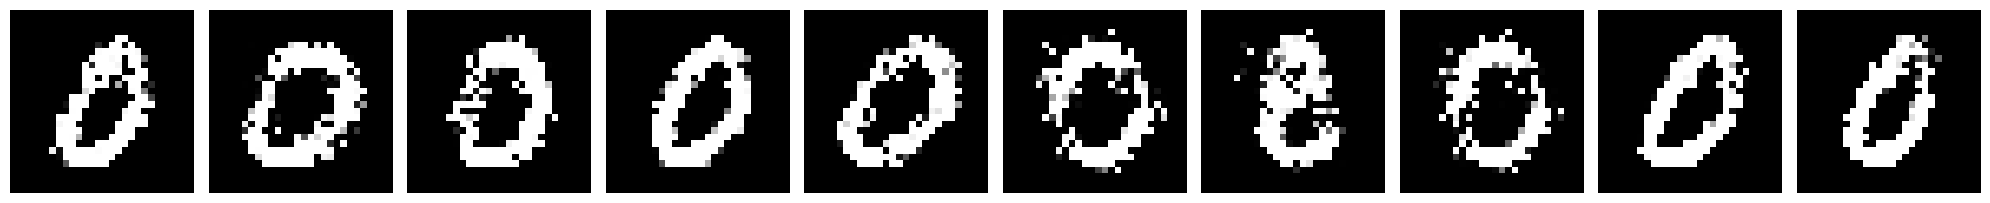

In [23]:
test_generator(generator, dim_latent)

torch.Size([10, 1, 28, 28])
0.9998396635055542 -0.9999999403953552


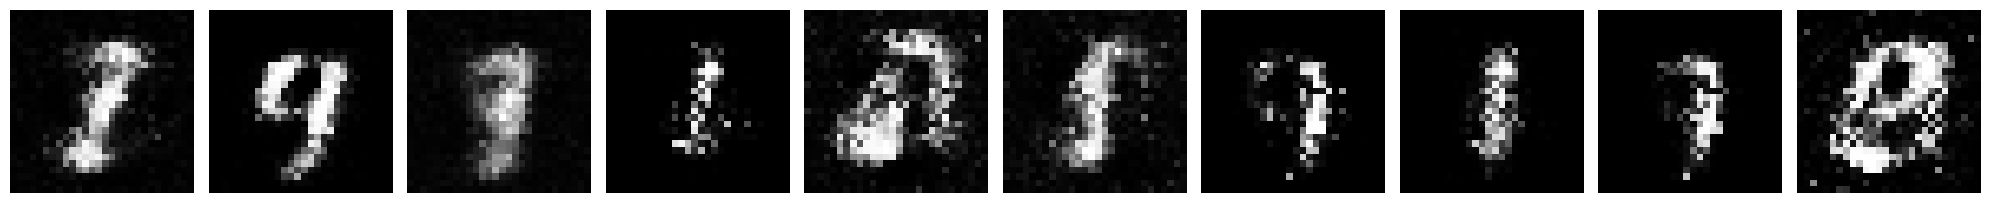

In [11]:
test_generator(generator, dim_latent)

torch.Size([10, 1, 28, 28])
0.9999999403953552 -1.0


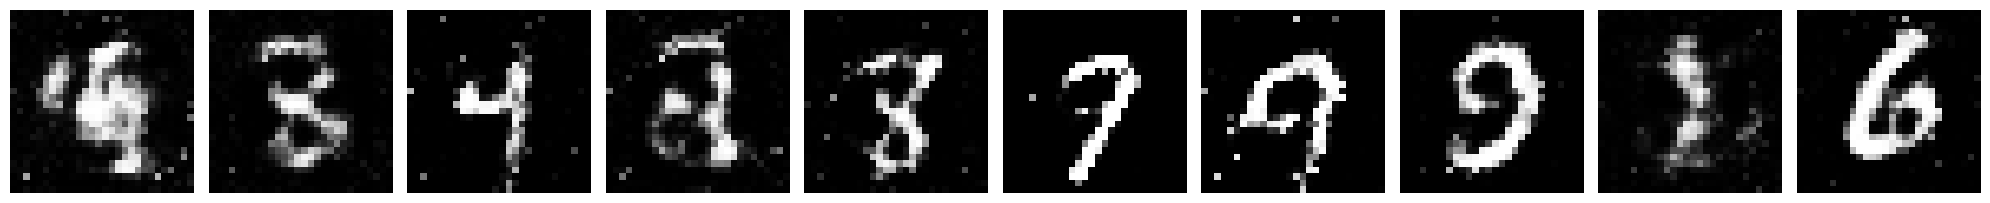

In [58]:
test_generator(generator, dim_latent)

0.6474512815475464 0.34635448455810547


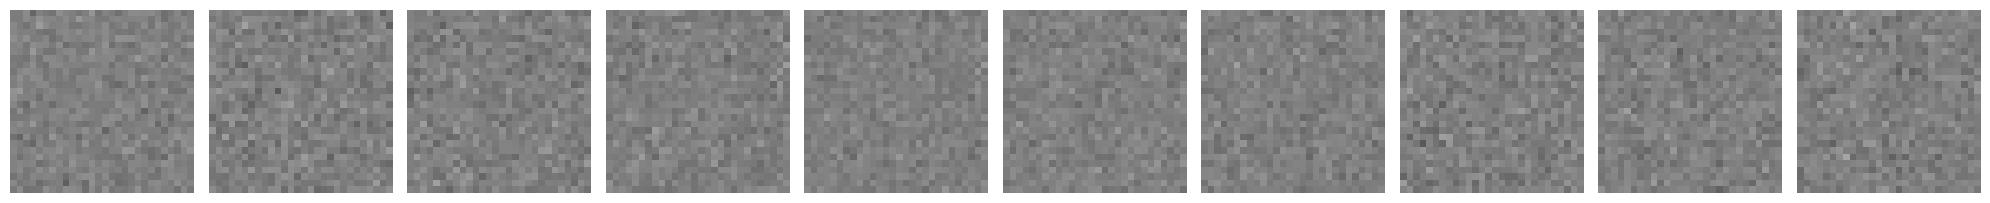

In [70]:
test_generator(generator, dim_latent)

0.6548554301261902 0.3558650612831116


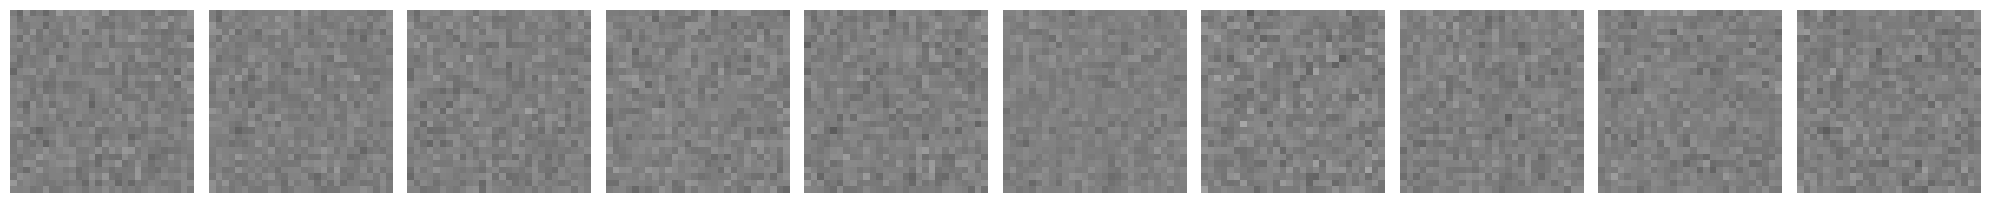

In [68]:
test_generator(generator, dim_latent)

0.568766176700592 -0.5611801147460938


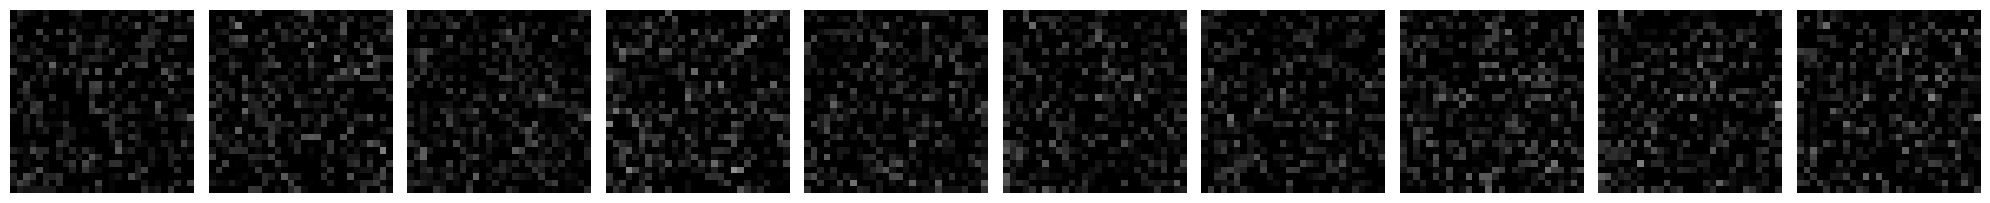

In [63]:
test_generator(generator, dim_latent)

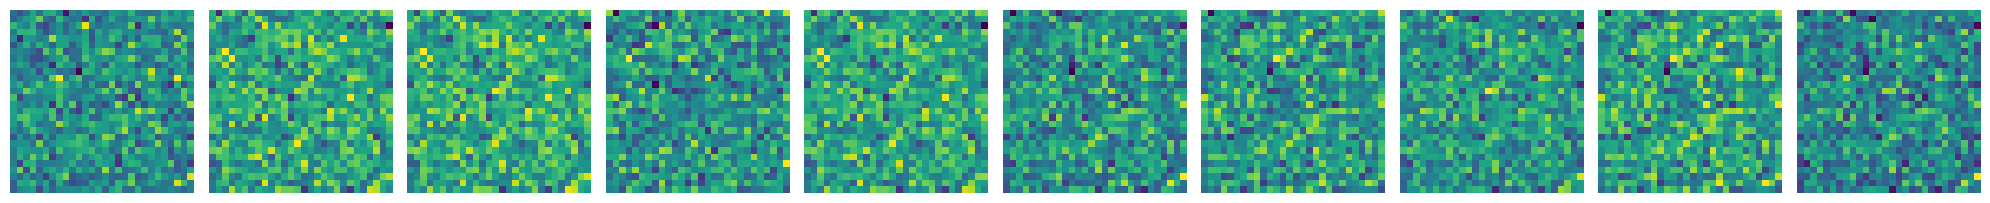

In [37]:
test_generator(generator)

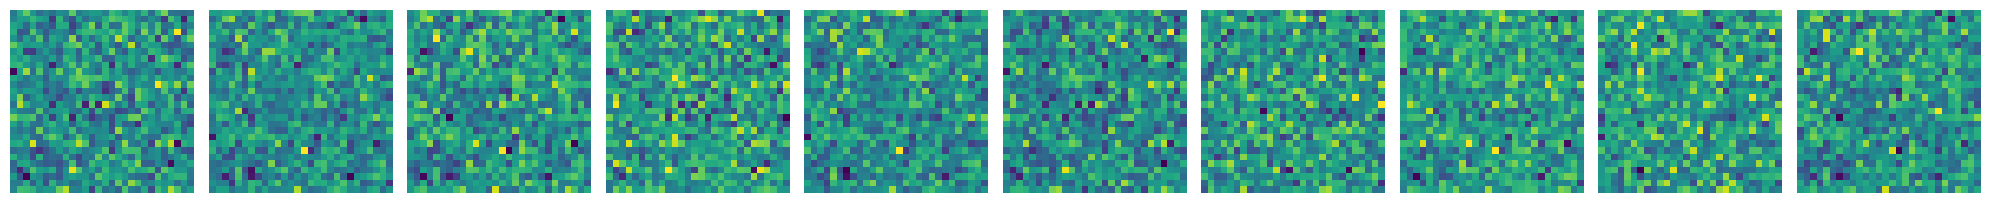

In [8]:
test_generator(generator)

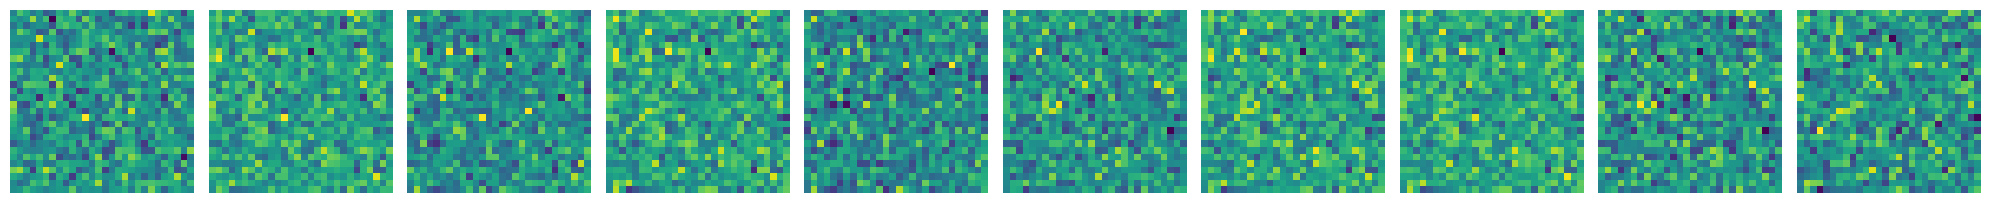

In [21]:
test_generator(generator)

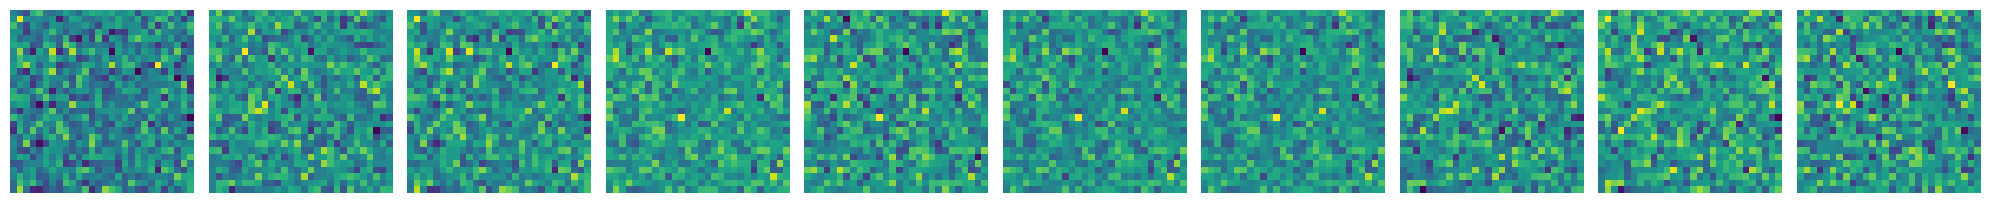

In [24]:
test_generator(generator)